# Storing Credentials Securely

When writing Python code to be executed in a batch mode, it is important to ensure that the credentials required to connect to Granta MI (and any other server) are stored securely.

## Storing an Identity in Windows Task Scheduler for Autologon

If the server running Granta MI is on the same domain as the machine running the Python script, and the script is intended to be run automatically on a schedule, Task Scheduler can be used to store the identity that will run the script. The MI Scripting Toolkit `connect()` function can then be used with `autologon=True`, and the script will connect to Granta MI using the identity specified in the Task Scheduler task.

### Creating a Scheduled Task

The screenshot below shows what a typical Scheduled Task will look like when configured to run as a specific user. In this case, `python_user` is the user that the script will run as. Clicking **OK** will display a password prompt to store the password for that user.

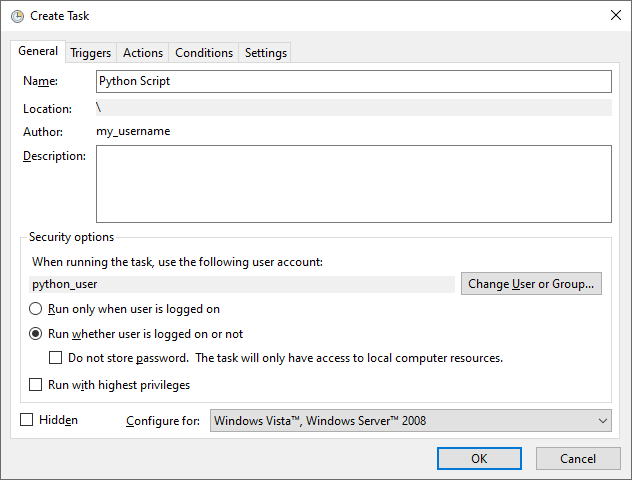

#### Triggers

Use the *Triggers* tab to configure when the script will execute. Generally this is specified in terms of certain days of the week and at a certain time of day.

#### Actions

Use the *Actions* tab to add the location of the Python executable and the script to be executed. In Windows, the Python executable is typically available either with `py` or `python`. If these are not available, you will need to specify the full path to the executable (accessible in Python by running `sys.executable`).

If you are executing your script in a virtual environment, we recommend writing a batch script that first activates the virtual environment before running the script. In this case, the *Actions* tab would reference the batch script, which in turn executes the Python script.

### Considerations

- We recommend running the script as a service principal which has been granted the permission "Log On As Batch Job".
- Make sure you select the radio button **Run whether user is logged on or not**, since in general the service principal will not be logged in.
- Uncheck the **Do not store password** box, since the session will need to access a remote Granta MI server. This means that if the password changes, it will need to be re-entered in Task Scheduler.

## Using `keyring` to Store Credentials for Password-Based Authentication

There are a number of scenarios where it does not make sense to use Task Scheduler in this way, for example:
- The script is running in Linux
- The script needs to run on-demand by a user without access to Task Scheduler
- The script needs to store credentials for a non-Windows account

In these scnearios, the [`keyring`](https://pypi.org/project/keyring/) Python package is recommended. It has cross-platform support by leveraging the [Windows Credential Locker](https://docs.microsoft.com/en-us/windows/uwp/security/credential-locker) in Windows or the [Secret Service API](https://www.gnu.org/software/emacs/manual/html_node/auth/Secret-Service-API.html) in Linux, which in turn relies on one of a number of different credential storage methods depending on the environment. In Ubuntu 18.04, the GNOME Password Manager is used.

### Considerations

Before proceeding, be aware of the following considerations when using `keyring`.

- `keyring` itself does not store the credentials, it relies on an external back end. Environments other than Windows and Ubuntu may provide these, but their configuration can be more complex. See the [`keyring` documentation](https://github.com/jaraco/keyring#readme) for more details.
- In Windows, all credentials stored by a user are visible to that user. As a result, any credentials stored by a shared or service account are visible to everyone with access to that account.
- In Ubuntu, credentials are only accessible if a password was used to log in. If the user was logged in automatically, the credential store must be unlocked before it can be accessed.
- `keyring` has a plug-in architecture, which is used to provide alternative (and potentially unsecured) back ends. However, these require installing additional packages from PyPI and manually selecting an alternative back end.

### Installing keyring

Installing `keyring` is typically done in the same way in both Windows and Ubuntu 18.04, despite the different credential storage back ends. The package can be installed using pip:

```
pip install keyring
```

You can confirm the back end in use by running the following on the command line:

```
keyring --list-backends
```

In Windows, this produces the following output, which indicates that the Windows Credential Locker will be used by default. If for some reason it is unavailable, `keyring` will fail, thus ensuring that credentials will not inadvertantly be stored using an unsecured method:

```
keyring.backends.Windows.WinVaultKeyring (priority: 5)
keyring.backends.fail.Keyring (priority: 0)
keyring.backends.chainer.ChainerBackend (priority: -1)
```

Running the same command on Ubuntu 18.04 produces a similar output.

```
keyring.backends.SecretService.Keyring (priority: 5)
keyring.backends.chainer.ChainerBackend (priority: -1)
keyring.backends.fail.Keyring (priority: 0)
```

### Storing Credentials Using the Command Line

The simplest way to store a credential using `keyring` is to use the command line.

The following command invokes the `keyring` Python package on the command line, and creates a new credential in the appropriate back end for the username `granta-admin-user` within the service `my-python-script`. We recommend setting the service to the name of the Python package.

```batch
keyring set my-python-script granta-admin-user
```

You will then be prompted for a password. Enter a password to store it securely using either Windows Credential Locker or Secret Service.

### Storing Credentials Programmatically

It is sometimes useful to store credentials programmatically in Python. This is the approach used in MI Scripting Toolkit to securely persist OpenID Connect (OIDC) tokens. The cells below demonstrate how to perform the same operation as above, but in Python:

In [1]:
import keyring

keyring.set_password("my-python-script", "granta-admin-user", "my_secret_password")

### Retreiving Credentials Programmatically

Credentials are retrieved programmatically similarly to how they are set.

In [2]:
keyring.get_password("my-python-script", "granta-admin-user")

'my_secret_password'

This password can now be provided to the MI Scripting Toolkit `connect()` method, or to any other Python function that requires a credential or other secret.

### Updating Credentials

Credentials are updated by simply setting the password for the same username and service.

In [3]:
keyring.set_password("my-python-script", "granta-admin-user", "my_super_secret_password")

keyring.get_password("my-python-script", "granta-admin-user")

'my_super_secret_password'

### Deleting Credentials

Passwords can be deleted with the `delete_password` function.

In [4]:
keyring.delete_password("my-python-script", "granta-admin-user")

Now calling `get_password()` will not retreive the password, since it has been deleted.

In [5]:
keyring.get_password("my-python-script", "granta-admin-user")

Credentials can also be deleted using the appropriate app, either Credential Manager in Windows, or Passwords and Keys in Ubuntu. They can also be deleted using the `keyring` command line interface.